## DataScience Project - Credit Card Fraud Detection 

## Importing Libraries and Dependencies

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:

#load the csv file as a data frame
filename = 'creditcard.csv'
df = pd.read_csv(filename)


## Data Preprocessing

In [3]:
# To get the rows and columns of the data set
df.shape

#To summarize the class distribution 
target = df.values[:, -1]
counter = Counter(target)
for k,v in counter.items():
    per = v/len(target) * 100
    print ('Class=%d, Count=%d, Percentage=%.3f%%' %(k, v, per))

Class=0, Count=284314, Percentage=99.827%
Class=1, Count=492, Percentage=0.173%


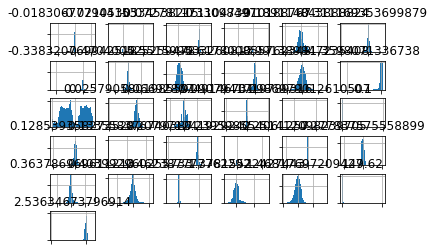

In [4]:
# Drop the last Column with all zero values
#df = df.drop(31, axis =1)

#create a histogram plot of each numeric variable
ax = df.hist(bins = 100)

#disable on axis labels to avoid the clutter
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
    
#show the plot
pyplot.show()

Above Histogram shows that majority of distribution is Gaussian with 99.827 percent of transactions marked as normal and 0.172 percent marked as fraudulent as shown in the counters above. 

In [5]:
df.shape

(284806, 31)

In [5]:

# summarize the amount variable
from pandas import read_csv
# define the dataset location
filename = 'creditcard.csv'
# load the csv file as a data frame
df = read_csv(filename, header=None)
# summarize the amount variable.
print(df[29].describe())

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: 29, dtype: float64


We can notice that most amounts are small with a mean of about 88 and middle 50% values are from 5 and 77 and the largest value is about 25691.16

## Model Test and Baseline Result

## Using the k-fold cross-validation procedure 

Setting the value of k = 10. When the total count is 284807 then each fold will contain 284807/10 or 28,480 examples. 

Stratified means each fold consist of 99.8 percent and 0.2 percent of normal and fraudulent transactions resepectively. 

Repeated means evaluation step will be performed multiple times to help avoid fluke results and better capture the variance of the model. In this case we will use 3 repeats.


In [6]:
#Load the dataset
full_path = 'creditcard.csv'
def load_dataset(full_path):
    #Load the dataset as numpy array
    data = read_csv(full_path, header= None)
    #retrieve numpy array
    data = data.values
    #split the data into input and out elements
    X, y = data[:, : -1], data[:, -1]
    return X, y


In [7]:
# Load the dataset and split the columns into inputs and outputs
def pr_auc(y_true, probas_pred):
    #calcultae precision-recall curve
    p,r, _ = precision_recall_curve(y_true, probas_pred)
    return auc(r,p)

In [8]:
# evaluate the model
def evaluate_model(X, y, model):
    #define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #define model evaluation metric
    metric = make_scorer(pr_auc, needs_proba = True)
    #evaluation model
    scores = cross_val_score(model, X, y, scoring= metric, cv=cv, n_jobs=-1)
    return scores

We can evaluate the baseline model using this test harness. A model that preducts class(class1 ) for all exaples will provide a baseline performance when using the precision-recall areas under the curve metric. 

This can be achieved by using Dummy Classifier - a classifier that does not generate any insight about the data and classifies the given data using simple rules. It gives you a measure of "baseline" performance for the success rate one should expect to achieve. 

Once the model is evaluated, then we can report the mean and standard deviated of the PR AUC scores directly 

In [9]:
#setting the full path to credit card csv file
full_path = 'creditcard.csv'
# load the dataset
X, y = load_dataset(full_path)
#summarize the loaded dataset
print (X.shape, y.shape, Counter(y))
#define the reference model
model = DummyClassifier(strategy='constant', constant = 1)
#evaluate the model
scores = evaluate_model(X, y, model)
#summarize performance
print('Mean PR AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

(284807, 30) (284807,) Counter({0.0: 284315, 1.0: 492})
Mean PR AUC: 0.501 (0.000)


## Evaluate Models

Now we will evaluate mixture of non linear algorithm models on the dataset.


Following Machine Learning models will be used for the credit card fraud dataset:
 - Decision Tree (CART)
 - k-Nearest Neighbors (KNN)
 - Bagged Decission Trees (BAG)
 - Random Forest (RF)
 - Extra Trees

In [ ]:
def get_models():
    models, names = list(), list()
    #CART
    models.append(DecisionTreeClassifier())
    names.append('CART')
    #KNN
    steps = [('s', StandardScaler()), ('m', KNeighborsClassifier())]
    models.append(Pipeline(steps=steps))
    names.append('KNN')
    #Bagging
    models.append(BaggingClassifier(n_estimators=100))
    names.append('BAG')
    #RF
    models.append(RandomForestClassifier(n_estimators=100))
    names.append('RF')
    #ET
    models.append(ExtraTreesClassifier(n_estimators=100))
    names.append('ET')
    return models, names

models, names = get_models()
results = list()
#evaluate each model
for i in range(len(models)):
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    #summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

*Please note that above section is highly processor intenseive.Make sure you have enough processing capacity and meomory on your system to run the above code due to the size of the dataset. 

Once we run above section of code pf model evaluation, the result we get is similar to 

CART 0.771 (0.049)
KNN 0.867 (0.033)
BAG 0.846 (0.045)
RF 0.855 (0.046)
ET 0.864 (0.040)

Highlighting KNN or KNearest Neighbour as the best performing model with PR AUC of 0.867